In [658]:
# Transformers 라이브러리
# - BERT, BigBird 등 다양한 모델의 아키텍처 제공
# - Hugging Face와 연동되어, Hugging Face에 있는 모델을 불러와 사용할 수 있음
!pip install transformers
!pip install datasets # Hugging Face와 연동

In [679]:
# Colab의 데이터 전송 속도 제한을 늘림
from IPython.display import display, Javascript
display(Javascript('''
    IPython.OutputArea.prototype._should_scroll = function(lines) {
        return false;
    }
'''))


<IPython.core.display.Javascript object>

### 1. 데이터 확인하기

In [680]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import argparse
import copy
import json
import logging
import os

import numpy as np

from tqdm import tqdm

import torch

from datasets import load_dataset
from sklearn.model_selection import train_test_split

import transformers
# 앞에 Auto가 붙은 것들은 "표준화된" 형식에 맞게 다양한 모델을 써볼 수 있게 도와주는 툴
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup


%matplotlib inline

In [681]:
df = pd.read_csv("/content/joongang_test.csv")
df = df.drop(columns=['date', 'article_url', '애매', 'label2'])
df.head(5)

,Unnamed: 0,title,content,label1
0,0,한동훈 “이화영 안되니 이제는 김성태냐”…野 “정치공세의 선봉장이냐”,한동훈 법무부 장관이 김성태 쌍방울 그룹 전 회장의 주가 조작 의혹을 수사 중인 검...,3
1,1,증오의 현실정치와 달랐다…역대 대통령 가족 6인의 靑 회동,역대 대통령의 가족들이 지난 29일 청와대에서 만나 청와대 개방 1주년 특별전 ‘우...,3
2,2,野 “쌍방울-친윤 법조 카르텔…‘구경꾼 장관’ 이상민 사퇴해야”,더불어민주당은 30일 김성태 전 쌍방울 회장 관련 ‘봐주기 기소’ 의혹을 제기하며 ...,1
3,3,"이준석 ""교권 회복? 제발 애 패는걸로 가지 않았으면 좋겠다""",이준석 국민의힘 전 대표는 서울 서초구 서이초등학교에서 신규교사가 '교권 침해' 의...,4
4,4,북·러 '반미 연대' 뭉쳤다…혈맹 중국보다 러시아 극진 대접,북한과 러시아가 한 몸처럼 뭉쳤다. 각각 핵·미사일 도발과 우크라이나 전쟁으로 세계...,4


In [682]:
# 1부터 5까지의 정수값만 포함하는 행만 선택합니다.
valid_labels = [1, 2, 3, 4, 5]
df = df[df['label1'].isin(valid_labels)]

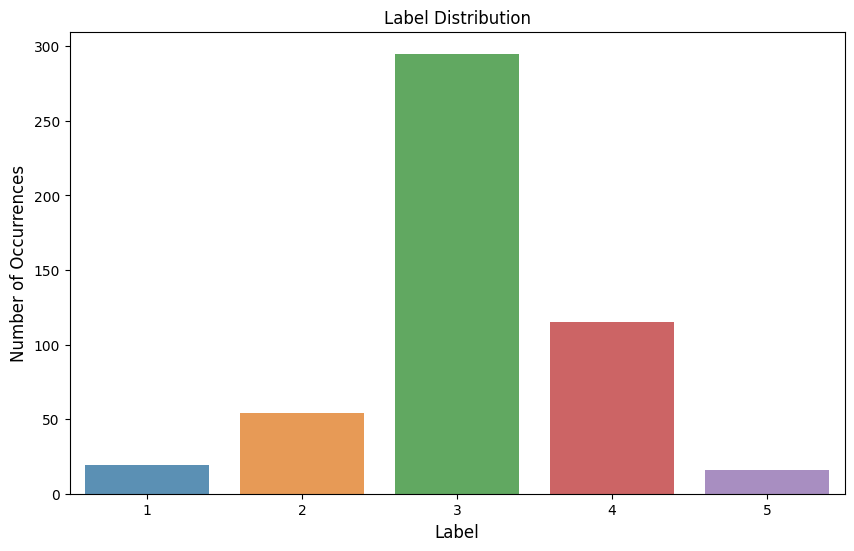

In [683]:
# 라벨별 카운트를 계산합니다.
label_counts = df['label1'].value_counts().sort_index()

# 막대 그래프로 시각화합니다.
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8)
plt.title('Label Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.xticks(ticks=range(0, 5), labels=[str(i) for i in range(1, 6)])  # x축 라벨을 1부터 5까지의 정수로 설정
plt.show()


In [684]:
label_counts = df['label1'].value_counts().sort_index()
print(label_counts)

1     19
2     54
3    295
4    115
5     16
Name: label1, dtype: int64


### 2. 기본 모델 클래스 정의

In [685]:
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("monologg/kobigbird-bert-base")  # BigBirdModel
tokenizer = AutoTokenizer.from_pretrained("monologg/kobigbird-bert-base")  # BertTokenizer

In [686]:
import torch
from transformers import AdamW, get_linear_schedule_with_warmup

class BaseModel(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.from_pretrained()

    def save_pretrained(self, save_dir):
        self.model.save_pretrained(save_dir)
        for key in ["special_tokens_map_file", "tokenizer_file"]:
            self.tokenizer.init_kwargs.pop(key, None)
        self.tokenizer.save_pretrained(save_dir)

    def from_pretrained(self):
        # We'll initialize the model and tokenizer in the child class
        raise NotImplementedError

    def forward(self, inputs):
        return self.model(**inputs)

    def eval_step(self, outputs):
        raise NotImplementedError

    def get_optimizer(self):
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.config.weight_decay,
            },
            {
                "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": self.config.weight_decay,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.config.learning_rate, eps=self.config.adam_epsilon)
        return optimizer

    def get_scheduler(self, batch_num, optimizer):
        if self.config.warmup_proportion == 0.0:
            return None

        t_total = batch_num // self.config.gradient_accumulation_steps * self.config.num_train_epochs

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(t_total * self.config.warmup_proportion),
            num_training_steps=t_total,
        )
        return scheduler

    def tensor_to_array(self, tensor):
        return tensor.detach().cpu().numpy()

    def tensor_to_list(self, tensor):
        return self.tensor_to_array(tensor).tolist()


In [687]:
class ClsModel(BaseModel):
    def __init__(self, config):
        super().__init__(config)

    # 사전 학습된 모델 가중치 불러오기
    def from_pretrained(self):
        # 실질적으로 Hugging Face에서 사전 학습된 모델을 불러와 초기화
        model_config = AutoConfig.from_pretrained(self.config.model_name_or_path, num_labels=self.config.num_labels)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.config.model_name_or_path, config=model_config, cache_dir=self.config.cache_dir
        )
        # BERT model과 별개로, 입력 문자열을 토큰의 index로 바꾸어주는 tokenizer가 사용됨
        self.tokenizer = AutoTokenizer.from_pretrained(self.config.model_name_or_path, cache_dir=self.config.cache_dir)

    def forward(self, inputs):
        outputs = self.model(**inputs)
        return outputs

    def eval_step(self, inputs, outputs):
        logits = outputs.logits.detach().cpu()
        predictions = self.tensor_to_list(torch.argmax(logits, dim=-1))
        labels = self.tensor_to_list(inputs["labels"])
        results = [{"prediction": prediction, "label": label} for prediction, label in zip(predictions, labels)]
        return results

In [688]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def cal_running_avg_loss(loss, running_avg_loss, decay=0.99):
    if running_avg_loss == 0:
        return loss
    running_avg_loss = running_avg_loss * decay + (1 - decay) * loss
    return running_avg_loss

In [689]:

data = {'text' : 'apple', 'label':'3'}
print(data['text'])

apple


### 데이터 전처리

In [700]:
def sample_writer(data):
  print(data)
  feature = tokenizer(
    data['text'],
    max_length=config.max_seq_length,
    padding="max_length",
    truncation=True,
    add_special_tokens=True,
  )
  write_data = {
      "input_ids": feature["input_ids"],
      "attention_mask": feature["attention_mask"],
      "labels": data["label"],
  }
  return write_data


def process_data_and_tokenize(config, data_file, is_train, tokenizer):
  df = pd.read_csv(data_file)
  # 1부터 5까지의 정수값만 포함하는 행만 선택합니다.
  valid_labels = [1, 2, 3, 4, 5]
  df = df[df['label1'].isin(valid_labels)]
  df = df.drop(columns=['date', 'article_url', '애매', 'label2'])
  labels = df["label1"].tolist()
  df = df.fillna("")  # NaN 값을 빈 문자열로 대체
  texts = (df["title"].astype(str) + " " + df["content"].astype(str)).tolist()

  # 데이터 리스트 생성
  data_list = [{"text": text, "label": label} for text, label in zip(texts, labels)]

  # 데이터 토큰화
  tokenized_data = [sample_writer(data_item) for data_item in data_list]
  print(tokenized_data)
  return tokenized_data


def collate_fn(features):
  input_ids = [sample["input_ids"] for sample in features]
  attention_mask = [sample["attention_mask"] for sample in features]
  labels = [sample["labels"] for sample in features]

  input_ids = torch.tensor(np.array(input_ids).astype(np.int64), dtype=torch.long)
  attention_mask = torch.tensor(np.array(attention_mask).astype(np.int8), dtype=torch.long)
  labels = torch.tensor(np.array(labels).astype(np.int64), dtype=torch.long)
  inputs = {
      "input_ids": input_ids,
      "attention_mask": attention_mask,
      "labels": labels,
  }
  return inputs

def train_split(config, texts, labels, is_train):
  x_train, x_val, y_train, y_val = train_test_split(
    texts, labels, test_size=0.2, random_state=config.seed, stratify=labels
  )
  if is_train:
    return x_train, y_train
  else:
    return x_val, y_val



In [701]:
import multiprocessing

def init_sample_writer(_config, _tokenizer, _is_train, _writer):
  global config
  global tokenizer
  global is_train
  global writer
  config = _config
  tokenizer = _tokenizer
  is_train = _is_train
  writer = _writer




def write_samples(config, tokenizer, is_train, writer_file, data, workers=4):
  # 전역 변수 설정
  init_sample_writer(config, tokenizer, is_train, None)
  write_cnt = 0
  with multiprocessing.Pool(
      processes=workers,
      initializer=init_sample_writer,
      initargs=(config, tokenizer, is_train, sample_writer),
  ) as pool:
      for write_data in tqdm(
          pool.imap(sample_writer, data), total=len(data), dynamic_ncols=True, desc="writing samples..."
      ):
          if isinstance(write_data, list):
              for datum in write_data:
                  writer_file.write(json.dumps(datum) + "\n")
              write_cnt += len(write_data)
          else:
              writer_file.write(json.dumps(write_data) + "\n")
              write_cnt += 1
  return write_cnt


# 그렇게 전처리가 완료된 파일에서 직접 배치 단위로 문자열을 읽어와서
# PyTorch의 Dataset으로 쓰는 코드
class IterableDatasetPad(torch.utils.data.IterableDataset):
  def __init__(
    self,
    dataset: torch.utils.data.IterableDataset,
    batch_size: int = 1,
    num_devices: int = 1,
    seed: int = 0,
):
    self.dataset = dataset
    self.batch_size = batch_size
    self.seed = seed
    self.num_examples = 0

    chunk_size = self.batch_size * num_devices
    length = len(dataset)
    self.length = length + (chunk_size - length % chunk_size)

  def __len__(self):
    return self.length

  def __iter__(self):
    self.num_examples = 0
    if (
      not hasattr(self.dataset, "set_epoch")
      and hasattr(self.dataset, "generator")
      and isinstance(self.dataset.generator, torch.Generator)
  ):
      self.dataset.generator.manual_seed(self.seed + self.epoch)

    first_batch = None
    current_batch = []
    for element in self.dataset:
        self.num_examples += 1
        current_batch.append(element)
        # Wait to have a full batch before yielding elements.
        if len(current_batch) == self.batch_size:
            for batch in current_batch:
                yield batch
                if first_batch is None:
                    first_batch = batch.copy()
            current_batch = []

    # pad the last batch with elements from the beginning.
    while self.num_examples < self.length:
        add_num = self.batch_size - len(current_batch)
        self.num_examples += add_num
        current_batch += [first_batch] * add_num
        for batch in current_batch:
            yield batch
        current_batch = []

In [702]:
import torch.utils.data as torch_data


def get_data(config, tokenizer, is_train=True, overwrite=False):
  if is_train:
    data_file = config.train_file
  else:
    data_file = config.predict_file

  data_path = config.data_dir
  if data_file is not None:
    data_path = os.path.join(data_path, data_file)
  else:
    data_path += "/"

  comps = [
      data_path,
      config.dataset,
      config.model_name_or_path.replace("/", "_"),
      config.max_seq_length,
      "train" if is_train else "dev",
      "dataset.txt",
  ]
  dataset_file = "_".join([str(comp) for comp in comps])
  print("dataset_file:", dataset_file)

  if not os.path.exists(dataset_file) or overwrite:
    with open(dataset_file, "w", encoding="utf-8") as writer_file:
      data = process_data_and_tokenize(config, data_path, is_train, tokenizer)
      cnt = write_samples(
      config, tokenizer, is_train, writer_file, data, workers=config.threads
      )

    print(f"{cnt} features processed from {data_path}")

  dataset = load_dataset("text", data_files=dataset_file, download_mode="force_redownload")["train"]
  dataset = dataset.map(lambda x: json.loads(x["text"]), batched=False)

  if not is_train:
    dataset = IterableDatasetPad(
          dataset=dataset,
          batch_size=config.train_batch_size if is_train else config.eval_batch_size,
          num_devices=config.world_size,
          seed=config.seed,
      )

    dataloader = torch.utils.data.DataLoader(
        dataset,
        sampler=torch.utils.data.RandomSampler(dataset) if is_train else None,
        drop_last=False,
        batch_size=config.train_batch_size if is_train else config.eval_batch_size,
        collate_fn=(collate_fn),
    )

  return dataloader

In [703]:
print(df.head())

   Unnamed: 0                                   title  \
0           0  한동훈 “이화영 안되니 이제는 김성태냐”…野 “정치공세의 선봉장이냐”   
1           1        증오의 현실정치와 달랐다…역대 대통령 가족 6인의 靑 회동   
2           2     野 “쌍방울-친윤 법조 카르텔…‘구경꾼 장관’ 이상민 사퇴해야”   
3           3      이준석 "교권 회복? 제발 애 패는걸로 가지 않았으면 좋겠다"   
4           4       북·러 '반미 연대' 뭉쳤다…혈맹 중국보다 러시아 극진 대접   

                                             content  label1  
0  한동훈 법무부 장관이 김성태 쌍방울 그룹 전 회장의 주가 조작 의혹을 수사 중인 검...       3  
1  역대 대통령의 가족들이 지난 29일 청와대에서 만나 청와대 개방 1주년 특별전 ‘우...       3  
2  더불어민주당은 30일 김성태 전 쌍방울 회장 관련 ‘봐주기 기소’ 의혹을 제기하며 ...       1  
3  이준석 국민의힘 전 대표는 서울 서초구 서이초등학교에서 신규교사가 '교권 침해' 의...       4  
4  북한과 러시아가 한 몸처럼 뭉쳤다. 각각 핵·미사일 도발과 우크라이나 전쟁으로 세계...       4  


### 모델 학습 및 평가

In [704]:
from functools import partial
import sklearn.metrics as sklearn_metrics

metrics = {
    "accuracy": sklearn_metrics.accuracy_score,
    "f1-macro": partial(sklearn_metrics.f1_score, average="macro"),
}

def eval_cls(results, **kwargs):
  predictions = np.array([result["prediction"] for result in results])
  labels = np.array([result["label"] for result in results])

  results = {
      metric: round(f(labels, predictions) * 100, 2)
      for metric, f in metrics.items()
  }
  return {
      "results": results,
      "best_score": results["f1-macro"],
  }

In [705]:
def _run_epoch(model, loader, device=None, **kwargs):
  config = kwargs["config"]
  is_train = kwargs["is_train"]

  avg_loss = 0
  results = []
  batch_num = len(loader)

  if is_train:
      model.train()
      optimizer = kwargs["optimizer"]
      scheduler = kwargs["scheduler"]
  else:
      model.eval()

  pbar = tqdm(enumerate(loader), total=batch_num, dynamic_ncols=True)

  for i, inputs in pbar:
    for k, v in inputs.items():
      if isinstance(v, torch.Tensor):
          inputs[k] = v.to(device)

    outputs = model(inputs)
    loss = outputs.loss.mean()
    avg_loss = cal_running_avg_loss(loss.item(), avg_loss)
    loss /= config.gradient_accumulation_steps

    if is_train:
      loss.backward()
      if i % config.gradient_accumulation_steps == 0 or i == batch_num - 1:
        if config.max_grad_norm > 0:
          torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None:
          scheduler.step()
    else:
        result = (model.module if hasattr(model, "module") else model).eval_step(inputs, outputs)
        results.extend(result)

    pbar.set_description(
        f"epoch: {kwargs['epoch'] + 1}, {('train' if is_train else 'valid')} loss: {min(100, round(avg_loss, 4))}"
    )

    return {
        "loss": avg_loss,
        "result": results,
    }

def run_epoch(**kwargs):
  model = kwargs.pop("model")
  results = _run_epoch(model, **kwargs)

  if isinstance(results, list):
    loss = sum([result["loss"] for result in results]) / len(results)
    result = []
    for res in results:
      result.extend(res["result"])
    results = {"loss": loss, "result": result}

  return results


### 하이퍼파라미터 설정

In [706]:
from types import SimpleNamespace

config = SimpleNamespace()

config.task = "cls"
config.dataset = "joongang"

config.cache_dir = "/content/"
config.output_dir = "output"

config.use_tpu = False
config.model_name_or_path = "monologg/kobigbird-bert-base"
config.data_dir = "/content/"

config.train_file = "joongang_test.csv"
config.predict_file = "joongang_test.csv"

config.max_seq_length = 1024
config.train_batch_size = 4
config.eval_batch_size = 2

config.learning_rate = 3e-5
config.num_train_epochs = 10

config.num_labels = 5
config.gradient_accumulation_steps = 2

config.threads = 4
config.seed = 42

config.do_train = True
config.do_eval_during_train = True
config.do_eval = True

config.do_lower_case = False
config.weight_decay = 0.0
config.adam_epsilon = 1e-8
config.max_grad_norm = 1.0
config.warmup_proportion = 0.0

In [707]:
if not os.path.exists(config.cache_dir):
  os.makedirs(config.cache_dir)

output_dir = os.path.join(config.output_dir, config.task, config.dataset)
print("Output directory:", output_dir)
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

Output directory: output/cls/joongang


### 딥러닝 모델 초기화하기

In [708]:
# 현재 모델 이름이 "monologg/kobigbird-bert-base" 이므로, Hugging Face에서 찾아서 불러옴
set_seed(config.seed)

# 딥러닝 모델 초기화
model = ClsModel(config)
model.from_pretrained()

print(f"configuration: {str(config)}")

if torch.cuda.is_available(): # GPU를 사용할 수 있다면
  gpu_count = torch.cuda.device_count()
  print(f"{gpu_count} GPU device detected")
  devices = ["cuda:{}".format(i) for i in range(gpu_count)]
  model_dp = torch.nn.DataParallel(model, device_ids=devices)
  model.to(devices[0])
else: # GPU를 사용할 수 없다면 CPU로 구동
  devices = ["cpu"]
  model_dp = model

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


configuration: namespace(task='cls', dataset='joongang', cache_dir='/content/', output_dir='output', use_tpu=False, model_name_or_path='monologg/kobigbird-bert-base', data_dir='/content/', train_file='joongang_test.csv', predict_file='joongang_test.csv', max_seq_length=1024, train_batch_size=4, eval_batch_size=2, learning_rate=3e-05, num_train_epochs=10, num_labels=5, gradient_accumulation_steps=2, threads=4, seed=42, do_train=True, do_eval_during_train=True, do_eval=True, do_lower_case=False, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, warmup_proportion=0.0)


### 데이터 및 학습 세팅 초기화하기

In [709]:
config.world_size = len(devices)
if config.do_train:
  train_loader = get_data(config, tokenizer=model.tokenizer, overwrite=True) # 이 코드를 처음 실행하는 경우
  # train_loader = get_data(config, tokenizer=model.tokenizer, overwrite=False) # 한 번 데이터 처리를 한 경우
valid_loader = get_data(config, tokenizer=model.tokenizer, is_train=False)

optimizer = None
scheduler = None
if config.do_train: # 학습 모드(train mode)인 경우
  optimizer = model.get_optimizer()
  scheduler = model.get_scheduler(len(train_loader), optimizer)

params = {
    "config": config,
    "model": model_dp,
    "optimizer": optimizer,
    "scheduler": scheduler,
}
if not config.use_tpu:
  params["device"] = devices[0]


dataset_file: /content/joongang_test.csv_joongang_monologg_kobigbird-bert-base_1024_train_dataset.txt
{'text': "한동훈 “이화영 안되니 이제는 김성태냐”…野 “정치공세의 선봉장이냐” 한동훈 법무부 장관이 김성태 쌍방울 그룹 전 회장의 주가 조작 의혹을 수사 중인 검찰에 대해 ‘봐주기 식’ 기소라고 비판한 더불어민주당을 겨냥해 30일 “이화영 전 경기도 평화부지사로 압박하다가 안 될 것 같으니, 이제는 김성태로 압박하는 ‘타킷 변경’이냐”며 맞받아쳤다.\n\n이날 한 장관은 입장문을 통해 이같이 밝히며 “자신들의 당대표에 대한 범죄 수사를 막기 위한 사법 방해에 저렇게 다수당의 정치권력을 총동원해 집요하게 올인하는 것은, ‘정치의 영역’이 아니라 증거인멸이나 위증교사와 같은 ‘범죄의 영역'에 가깝다”고 비판했다.\n\n이어 “도지사의 방북을 위해 깡패를 시켜, 북한 뒷돈을 갖다 바치는 행위는 민주당과 무관한 개인비리”라고 강조했다.\n\n이에 대해 권칠승 민주당 수석대변인은 국회 브리핑을 열고 “법무부 장관이 정치 공세 선봉장인가”라며 “검찰의 야당탄압 수사를 비판했는데 한동훈 장관이 나섰다. 누가 야당탄압 수사의 배후인지 짐작하게 한다”고 밝혔다.\n\n권 수석대변인은 “야당 대표를 옭아매기 위해 쌍방울 김성태 전 회장을 회유하고 봐주기 수사하고 있다는 민주당의 주장이 그렇게 뼈 아팠냐”며 “수사 중인 사안에 법무부 장관이 단정적으로 혐의를 규정하고 정치 공세의 선봉장을 자임하고 있으니 기가 막힌다”고 했다.\n\n그러면서 “검찰의 야당탄압 수사를 한동훈 장관이 진두지휘하고 있다고 판단할 수밖에 없다”며 “한동훈 장관은 ‘무법부’ 장관인가? 한동훈 장관은 법무부의 흑역사로 남을 수사 개입을 당장 중단하기 바란다”고 덧붙였다.", 'label': 3}
{'text': '증오의 현실정치와 달랐다…역대 대통령 가족 6인의 靑 회동 역대 대통령의 가족들이 지난 29일 청와대에서 만

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

writing samples...:   0%|          | 0/499 [00:00<?, ?it/s]

{'input_ids': [2, 4224, 4743, 5339, 702, 13883, 4697, 3571, 5189, 4623, 6892, 4741, 24507, 5278, 703, 707, 2398, 702, 6893, 4703, 4773, 4561, 19950, 30681, 5278, 703, 4224, 4743, 5339, 12089, 7358, 4544, 24507, 18676, 4851, 7218, 3768, 7088, 4561, 8239, 9449, 8081, 4604, 7321, 3815, 4627, 7387, 4584, 6827, 700, 3299, 4667, 4583, 3507, 701, 9169, 6980, 7385, 4837, 8059, 4674, 20612, 4604, 11578, 4671, 6921, 4709, 702, 13883, 4697, 3768, 7754, 7746, 29741, 4518, 4618, 9294, 4681, 8034, 3571, 2937, 2579, 2556, 9264, 516, 6892, 4741, 24507, 4618, 9294, 4681, 4741, 700, 4065, 5758, 8144, 701, 3729, 5278, 703, 3185, 3154, 5090, 4619, 5944, 4742, 518, 7021, 4224, 7358, 4839, 7158, 4562, 4604, 6826, 3729, 14352, 8737, 4990, 702, 6821, 4644, 4561, 13086, 5000, 4584, 6800, 8129, 7321, 4874, 3144, 4583, 6878, 9319, 9539, 4584, 13880, 8923, 4820, 4561, 27190, 4604, 22326, 4671, 20119, 4681, 4696, 22241, 4681, 4741, 2579, 4839, 516, 700, 6893, 4561, 7961, 701, 3729, 6799, 4744, 8521, 4627, 5587, 19

writing samples...:   0%|          | 0/499 [00:00<?, ?it/s]

{'input_ids': [2, 15363, 4561, 7223, 4712, 4885, 4756, 12032, 4742, 707, 9208, 6887, 7135, 526, 4627, 4561, 2468, 13628, 9208, 6887, 4561, 7135, 10707, 6809, 7477, 4709, 7741, 31318, 7224, 7741, 9018, 521, 4667, 5161, 7192, 4704, 700, 6801, 6887, 4644, 4561, 6954, 701, 3128, 6834, 8956, 5411, 4742, 518, 12951, 3768, 6887, 13867, 3789, 5034, 4528, 11759, 516, 3715, 4621, 4805, 3768, 6887, 7310, 19896, 4531, 7019, 4618, 14227, 16274, 3308, 4544, 25424, 516, 11306, 3768, 6887, 7310, 10316, 4830, 541, 4714, 7088, 516, 21132, 3768, 6887, 7310, 2821, 4811, 4645, 12610, 9933, 13127, 9545, 516, 16451, 3768, 6887, 7310, 10966, 4994, 16451, 4540, 6883, 20386, 16274, 9545, 516, 11451, 3768, 6887, 7310, 18399, 4554, 11451, 4567, 4603, 13127, 9545, 2968, 526, 4653, 4544, 7626, 5411, 4742, 518, 3729, 4644, 4839, 7021, 7643, 3594, 521, 12339, 4771, 5284, 700, 6969, 6887, 10707, 3738, 5070, 4742, 701, 2856, 19617, 4874, 2876, 10570, 4874, 8009, 6179, 4742, 518, 14444, 4644, 4839, 702, 6859, 9652, 4839

KeyError: ignored